# Autoencoder主要程式

## 套用所需要之套件

In [0]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import random, time

from tensorflow.examples.tutorials.mnist import input_data

/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 定義Autoencoder類別

In [0]:
class Autoencoder(object):
    def __init__(self,n_features,learning_rate=0.5,n_hidden=[1000,500,250,2],alpha=0.0):
        self.n_features = n_features
        
        self.weights = None
        self.biases = None
        
        self.graph = tf.Graph() # initialize new grap
        self.build(n_features,learning_rate,n_hidden,alpha) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 
        
    def build(self,n_features,learning_rate,n_hidden,alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.train_targets  = tf.placeholder(tf.float32, shape=(None,n_features))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss, _ = self.structure(
                                               features=self.train_features,
                                               targets=self.train_targets,
                                               n_hidden=n_hidden)
            
            # regularization loss
            # weight elimination L2 regularizer
            self.regularizer = tf.reduce_sum([tf.reduce_sum(
                        tf.pow(w,2)/(1+tf.pow(w,2))) for w in self.weights.values()]) \
                    / tf.reduce_sum(
                     [tf.size(w,out_type=tf.float32) for w in self.weights.values()])
                                                                    
            # total loss
            self.loss = self.original_loss + alpha * self.regularizer
            
            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            
            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_targets  = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_y_, self.new_original_loss, self.new_encoder = self.structure(
                                                          features=self.new_features,
                                                          targets=self.new_targets,
                                                          n_hidden=n_hidden)  
            self.new_loss = self.new_original_loss + alpha * self.regularizer
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()  
    
    def structure(self,features,targets,n_hidden):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {}
            self.biases = {}
            
            n_encoder = [self.n_features]+n_hidden
            for i,n in enumerate(n_encoder[:-1]):
                self.weights['encode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n,n_encoder[i+1]),stddev=0.1),dtype=tf.float32)
                self.biases['encode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros( shape=(n_encoder[i+1]) ),dtype=tf.float32)
            
            n_decoder = list(reversed(n_hidden))+[self.n_features]
            for i,n in enumerate(n_decoder[:-1]):
                self.weights['decode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n,n_decoder[i+1]),stddev=0.1),dtype=tf.float32)
                self.biases['decode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros( shape=(n_decoder[i+1]) ),dtype=tf.float32)                    

        ### Structure
        activation = tf.nn.relu
        
        encoder = self.getDenseLayer(features,
                                     self.weights['encode1'],
                                     self.biases['encode1'],
                                     activation=activation)

        for i in range(1,len(n_hidden)-1):
            encoder = self.getDenseLayer(encoder,
                        self.weights['encode{}'.format(i+1)],
                        self.biases['encode{}'.format(i+1)],
                        activation=activation)   

        encoder = self.getDenseLayer(encoder,
                        self.weights['encode{}'.format(len(n_hidden))],
                        self.biases['encode{}'.format(len(n_hidden))]) 

        decoder = self.getDenseLayer(encoder,
                                     self.weights['decode1'],
                                     self.biases['decode1'],
                                     activation=activation)
        
        for i in range(1,len(n_hidden)-1):
            decoder = self.getDenseLayer(decoder,
                        self.weights['decode{}'.format(i+1)],
                        self.biases['decode{}'.format(i+1)],
                        activation=activation) 
        
        y_ =  self.getDenseLayer(decoder,
                        self.weights['decode{}'.format(len(n_hidden))],
                        self.biases['decode{}'.format(len(n_hidden))],
                        activation=tf.nn.sigmoid)      
        
        loss = tf.reduce_mean(tf.pow(targets - y_, 2))

        return (y_,loss,encoder)
    
    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x
    
    
    def fit(self,X,Y,epochs=10,validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        Y = self._check_array(Y)
        
        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N
        
        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            start_time = time.time()
            
            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size,index_size))]     
            
                feed_dict = {self.train_features: X[batch_index,:],
                             self.train_targets: Y[batch_index,:]}
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

                print("[%d/%d] loss = %9.4f     " % ( N-len(index), N, loss ), end='\r')
                
            
            # evaluate at the end of this epoch
            msg_valid = ""
            if validation_data is not None:
                val_loss = self.evaluate(validation_data[0],validation_data[1])
                msg_valid = ", val_loss = %9.4f" % ( val_loss )
            
            train_loss = self.evaluate(X,Y)
            print("[%d/%d] %ds loss = %9.4f %s" % ( N, N, time.time()-start_time,
                                                   train_loss, msg_valid ))
            
        if test_data is not None:
            test_loss = self.evaluate(test_data[0],test_data[1])
            print("test_loss = %9.4f" % (test_loss))
    
    def encode(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_encoder, feed_dict={self.new_features: X})
    
    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})
    
    def evaluate(self,X,Y):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X,
                                                       self.new_targets: Y})
    
    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Epoch  1/20: 
[55000/55000] 36s loss =    0.0327 , val_loss =    0.0322
Epoch  2/20: 
[55000/55000] 33s loss =    0.0296 , val_loss =    0.0295
Epoch  3/20: 
[55000/55000] 32s loss =    0.0285 , val_loss =    0.0284
Epoch  4/20: 
[55000/55000] 29s loss =    0.0276 , val_loss =    0.0275
Epoch  5/20: 
[55000/55000] 31s loss =    0.0271 , val_loss =    0.0272
Epoch  6/20: 
[55000/55000] 31s loss =    0.0266 , val_loss =    0.0268
Epoch  7/20: 
[55000/55000] 32s loss =    0.0263 , val_loss =    0.0265
Epoch  8/20: 
[55000/55000] 32s loss =    0.0260 , val_loss =    0.0264
Epoch  9/20: 
[55000/55000] 31s loss =    0.0257 , val_loss =    0.0261
Epoch 10/20: 
[55000/55000] 33s loss =    0.0254 , val_loss =    0.0258
Epoch 11/20: 
[55000/55000] 31s loss =    0.0255 , val_loss =    0.0260
Epoch 12/20: 
[55000/55000] 32s loss =    0.0250 , val_loss =    0.0256
Epoch 13/20: 
[55000/55000] 32s loss =    0.0249 , val_loss =    0.0256
Epoch 14/20: 
[55000/55000] 32s loss =    0.0248 , val_loss =   

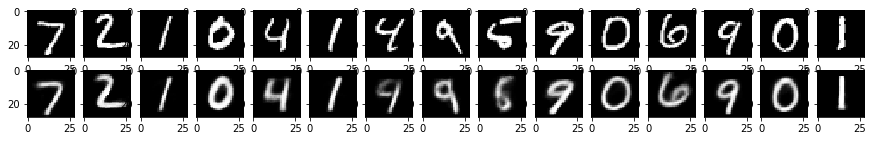

In [0]:
model_1 = Autoencoder( n_features=28*28,
                     learning_rate= 0.0005,
                     n_hidden=[512,32,4],
                     alpha=0.0,
                    )
model_1.fit(X=train_data.images,
           Y=train_data.images,
           epochs=20,
           validation_data=(valid_data.images,valid_data.images),
           test_data=(test_data.images,test_data.images),
           batch_size = 8,
          )

fig, axis = plt.subplots(2, 15, figsize=(15, 2))
for i in range(0,15):
    img_original = np.reshape(test_data.images[i],(28,28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model_1.predict(test_data.images[i]),(28,28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()

Epoch  1/20: 
[55000/55000] 46s loss =    0.0331 , val_loss =    0.0326
Epoch  2/20: 
[55000/55000] 42s loss =    0.0299 , val_loss =    0.0298
Epoch  3/20: 
[55000/55000] 45s loss =    0.0287 , val_loss =    0.0286
Epoch  4/20: 
[55000/55000] 47s loss =    0.0277 , val_loss =    0.0277
Epoch  5/20: 
[55000/55000] 48s loss =    0.0273 , val_loss =    0.0274
Epoch  6/20: 
[55000/55000] 45s loss =    0.0268 , val_loss =    0.0270
Epoch  7/20: 
[55000/55000] 45s loss =    0.0264 , val_loss =    0.0266
Epoch  8/20: 
[55000/55000] 60s loss =    0.0261 , val_loss =    0.0265
Epoch  9/20: 
[55000/55000] 49s loss =    0.0258 , val_loss =    0.0262
Epoch 10/20: 
[55000/55000] 60s loss =    0.0255 , val_loss =    0.0259
Epoch 11/20: 
[55000/55000] 91s loss =    0.0254 , val_loss =    0.0260
Epoch 12/20: 
[55000/55000] 90s loss =    0.0250 , val_loss =    0.0256
Epoch 13/20: 
[55000/55000] 93s loss =    0.0248 , val_loss =    0.0256
Epoch 14/20: 
[55000/55000] 87s loss =    0.0248 , val_loss =   

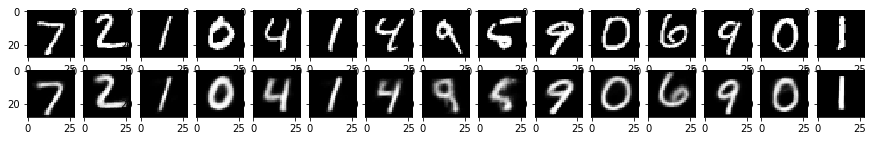

In [0]:
model_2 = Autoencoder( n_features=28*28,
                     learning_rate= 0.0005,
                     n_hidden=[512,32,4],
                     alpha=0.001,
                    )
model_2.fit(X=train_data.images,
           Y=train_data.images,
           epochs=20,
           validation_data=(valid_data.images,valid_data.images),
           test_data=(test_data.images,test_data.images),
           batch_size = 8,
          )

fig, axis = plt.subplots(2, 15, figsize=(15, 2))
for i in range(0,15):
    img_original = np.reshape(test_data.images[i],(28,28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model_2.predict(test_data.images[i]),(28,28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()

## 壓縮碼Code與視覺化

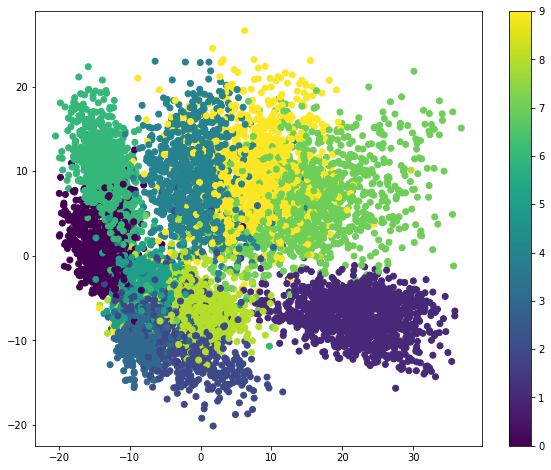

In [0]:
    ### get code
    encode = model_2.encode(test_data.images)
    
    ### PCA 2D visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X = pca.fit_transform(encode)
    Y = np.argmax(test_data.labels, axis=1)
    
    # plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=Y)
    plt.colorbar()
    plt.show()


In [0]:
# get code
encode = model_2.encode(test_data.images)

# TSNE 2D visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(encode)
Y = np.argmax(test_data.labels, axis=1)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y)
plt.colorbar()
plt.show()